# Entrenamiento de modelos
Este notebook servirá para el entrenamiento de los modelos usados para el TFM, usando la GPU que proporciona Google Collab Pro.

## Imports y parámetros

In [2]:
!pip install datasets
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [3]:
# Imports necesarios
import pandas as pd
from datasets import Dataset
import torch
import os
import tensorflow as tf
from datasets import Dataset
import evaluate
from itertools import product
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from transformers import EarlyStoppingCallback

In [4]:
# Cargamos la carpeta de Drive
from google.colab import drive
drive.mount('/content/drive')
carpeta = '/content/drive/My Drive/Facultad/Máster/TFM'

Mounted at /content/drive


In [5]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')
!nvidia-smi

2.18.0
Sun Jun 22 18:09:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             42W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+----------------------------------------

In [21]:
# Variables para entrenamiento
# model_name = "bert-base-uncased"  # "answerdotai/ModernBERT-base"
model_name = "bert-base-uncased"

dataset = "edos_labelled_3_sexism_grade_reduced.csv"

# Carpetas donde está el dataset y se almacenará el modelo
carpeta_dataset = carpeta + f"/Datos/{dataset}"
carpeta_modelos = carpeta + f"/Modelos/{model_name.split('/')[-1]}"

# Obtenemos la localización del modelo
model_path = carpeta_modelos
model_path += f"/{dataset.split('.')[0]}"

# Obtenemos la carpeta de los resultados
carpeta_resultados = carpeta + f"/Resultados/{dataset}/{model_name.split('/')[-1]}"
csv_result = carpeta_resultados + "/resultados.csv"

# Comprobamos si existe la carpeta de resultados
if not os.path.exists(os.path.dirname(csv_result)):
    os.makedirs(os.path.dirname(csv_result))

# Obtenemos el CSV de la carpeta resultados si existe
if os.path.exists(csv_result):
  # Cargamos los resultados que ya tenemos
  df_results = pd.read_csv(csv_result)
  all_results = df_results.to_dict('records')
else:
  all_results = []
  df_results = pd.DataFrame(columns=["model_name","num_epochs","strategy","learning_rate","weight_decay","batch_size","eval_loss","eval_accuracy","eval_precision","eval_recall","eval_f1","eval_runtime","eval_samples_per_second","eval_steps_per_second","epoch"])

In [22]:
print(df_results.to_dict('records'))

[]


## Funciones necesarias

In [8]:
# Carga del dataset
def load_dataset():
  # Cargar el dataset desde CSV
  df = pd.read_csv(carpeta_dataset)

  # Asegurar que las columnas 'text', 'sexism_grade' y 'split' existen
  if not all(col in df.columns for col in ["text", "sexism_grade", "split"]):
      raise ValueError(
          "El CSV de EDOS debe contener las columnas 'text', 'sexism_grade' y 'split'."
      )

  # Renombramos las columnas (convención HF)
  df = df.rename(columns={"text": "comment", "sexism_grade": "label"})

  return df

In [9]:
# Función para obtener los parámetros como texto
def format_params(params: dict):
  # Formateamos los parámetros -> KEY: VALUE | ...
  return " | ".join(f"{key}: {value}" for key, value in params.items())

In [10]:
# Almacenar resultados
def save_results(metrics, params, result_path=carpeta_resultados):
  # Comprobamos que exista
  if not os.path.exists(os.path.dirname(result_path)):
    os.makedirs(os.path.dirname(result_path))

  # Comprobamos que exista
  if not os.path.exists(os.path.dirname(result_path)):
    os.makedirs(os.path.dirname(result_path))

  # Creamos el archivo
  result_file = result_path + "/resultados.log"

  # Formateamos los parámetros -> KEY: VALUE | ...
  text_params = format_params(params)

  # Guardamos resultados
  with open(result_file, "a") as f:
      f.write(f"Test metrics: {metrics} \| PARAMS \| {text_params}\n")

In [11]:
# Almacenar resultados en un CSV
def save_results_csv(metrics, params, result_path=carpeta_resultados):
  # Nombre del archivo
  csv_result = result_path + "/resultados.csv"

  # Creamos un diccionario con metrics + params
  results = {**params, **metrics}
  all_results.append(results)

  print(f"Almacenando resultados: {results}")

  # Creamos un dataframe con los resultados
  df_resultados = pd.DataFrame([results])

  # Creamos la carpeta si no existe
  if not os.path.exists(os.path.dirname(csv_result)):
    os.makedirs(os.path.dirname(csv_result))

  # Obtenemos el CSV de la carpeta resultados si existe
  if os.path.exists(csv_result):
    # Leemos primero los resultados que haya y añadimos después
    df_resultados = pd.concat([pd.read_csv(csv_result), df_resultados], ignore_index=True)

  # Añadimos el dataframe entero
  df_resultados.to_csv(csv_result, index=False)

In [23]:
# Función para entrenamiento
def train_model(model_name, df, model_path, num_train_epochs=11, strategy="epoch",
                learning_rate=2e-5, weight_decay=0.001, batch_size=16,
                early_stopping_patience=3, save_model=True, f1_results=[]):
  # Obtenemos los parámetros para printearlos
  params = {
      "model_name": model_name,
      "num_epochs": num_train_epochs,
      "strategy": strategy,
      "learning_rate": learning_rate,
      "weight_decay": weight_decay,
      "batch_size": batch_size
  }
  print(format_params(params))

  print(df["label"].unique())

  # Dividimos el dataset en sus splits
  df_train = df[df["split"] == "train"]
  df_dev = df[df["split"] == "dev"]
  df_test = df[df["split"] == "test"]

  # Convertir cada split en Dataset
  dataset_train = Dataset.from_pandas(df_train)
  dataset_dev = Dataset.from_pandas(df_dev)
  dataset_test = Dataset.from_pandas(df_test)

  # Convertir la columna "label" a un tipo ClassLabel (string -> int)
  dataset_train = dataset_train.class_encode_column("label")
  dataset_dev = dataset_dev.class_encode_column("label")
  if dataset_test is not None:
      dataset_test = dataset_test.class_encode_column("label")

  print(dataset_train.features["label"])     # Debe ser un ClassLabel con .num_classes==2
  print(dataset_train["label"][:10])

  print(dataset_dev.features["label"])     # Debe ser un ClassLabel con .num_classes==2
  print(dataset_dev["label"][:10])

  print(dataset_test.features["label"])     # Debe ser un ClassLabel con .num_classes==2
  print(dataset_test["label"][:10])

  label_names = dataset_train.features["label"].names

  # Cargar el tokenizador y modelo base
  tokenizer = AutoTokenizer.from_pretrained(model_name)
  model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_names))

  # Configurar 'label2id' e 'id2label' en el modelo para que devuelva
  #  directamente las etiquetas de texto
  label2id = {name: i for i, name in enumerate(label_names)}
  id2label = {i: name for i, name in enumerate(label_names)}
  model.config.label2id = label2id
  model.config.id2label = id2label

  # Función de tokenización
  def tokenize_function(example):
      return tokenizer(
          example["comment"], padding="max_length", truncation=True, max_length=128
      )

  # Tokenizamos cada subset
  dataset_train = dataset_train.map(tokenize_function, batched=True)
  dataset_dev = dataset_dev.map(tokenize_function, batched=True)
  if dataset_test is not None:
      dataset_test = dataset_test.map(tokenize_function, batched=True)

  # Eliminamos columnas que sobran
  dataset_train = dataset_train.remove_columns(["comment"])
  dataset_dev = dataset_dev.remove_columns(["comment"])
  if dataset_test is not None:
      dataset_test = dataset_test.remove_columns(["comment"])

  # Cargamos las métricas
  accuracy_metric = evaluate.load("accuracy")
  precision_metric = evaluate.load("precision")
  recall_metric = evaluate.load("recall")
  f1_metric = evaluate.load("f1")

  def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=preds, references=labels, average="macro")["precision"],
        "recall": recall_metric.compute(predictions=preds, references=labels, average="macro")["recall"],
        "f1": f1_metric.compute(predictions=preds, references=labels, average="macro")["f1"],
    }

  # Configurar argumentos de entrenamiento
  training_args = TrainingArguments(
      output_dir=model_path,
      eval_strategy=strategy,
      save_strategy=strategy,
      report_to=[],
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_train_epochs,
      weight_decay=weight_decay,
      load_best_model_at_end=True,
      metric_for_best_model="f1",
      greater_is_better=True,
      logging_dir="./logs",
      logging_steps=100,
      seed=42,
      fp16=True,
  )

  # Callback de early stopping
  early_stop = EarlyStoppingCallback(
      early_stopping_patience=early_stopping_patience,
      early_stopping_threshold=0.0
  )

  # Crear y ejecutar el Trainer
  trainer = Trainer(
      model=model,
      args=training_args,
      train_dataset=dataset_train,
      eval_dataset=dataset_dev,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[early_stop]
  )

  # Entrenar el modelo
  trainer.train()

  # Evaluar en test (si existe dataset_test)
  test_metrics = None
  if dataset_test is not None and len(dataset_test) > 0:
      print("Evaluando en el conjunto de test...")
      test_metrics = trainer.evaluate(dataset_test)
      print("Test metrics:", test_metrics)
      # Guardar resultados
      save_results_csv(metrics=test_metrics, params=params)
      #save_results(metrics=test_metrics)

      from sklearn.metrics import classification_report, confusion_matrix
      import matplotlib.pyplot as plt
      import seaborn as sns

      # Obtener predicciones en el conjunto de test
      predictions = trainer.predict(dataset_test)
      preds = predictions.predictions.argmax(axis=-1)
      labels = predictions.label_ids

      # Mostrar matriz de confusión
      conf_matrix = confusion_matrix(labels, preds)
      plt.figure(figsize=(8, 6))
      sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
                  xticklabels=model.config.id2label.values(),
                  yticklabels=model.config.id2label.values())
      plt.xlabel("Predicted label")
      plt.ylabel("True label")
      plt.title("Confusion Matrix")
      plt.show()

      # Mostrar clasificación detallada por clase
      report = classification_report(labels, preds, target_names=model.config.id2label.values())
      print("Classification Report:\n", report)

  # Guardar modelo y tokenizador si es el mejor
  is_best_model = False
  if test_metrics and "eval_f1" in test_metrics:
      current_f1 = test_metrics["eval_f1"]
      if not f1_results or current_f1 > max(f1_results):
          is_best_model = True
          f1_results.append(current_f1)
      else:
          print(f"No se guarda el modelo: F1 actual ({current_f1:.4f}) < F1 máximo anterior ({max(f1_results):.4f})")

  if is_best_model:
    print(f"✅ Modelo guardado como mejor modelo (F1 = {current_f1:.4f})")
    model.save_pretrained(model_path)
    tokenizer.save_pretrained(model_path)

  print(f"Modelo y tokenizador guardados en {model_path}")
  print(f"label2id: {model.config.label2id}")
  print(f"id2label: {model.config.id2label}")

## Entrenamiento y guardado del modelo

In [13]:
# Cargamos el dataset
df = load_dataset()

In [14]:
# Obtenemos los mejores modelos
top_5_results = {
  "bert-base-uncased": [
    {
      "model_name": "bert-base-uncased",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0,
      "batch_size": 32,
      "eval_loss": 0.446518063545227,
      "eval_accuracy": 0.8258706467661692,
      "eval_precision": 0.831275720164609,
      "eval_recall": 0.8128772635814889,
      "eval_f1": 0.8219735503560529,
      "eval_runtime": 0.7256,
      "eval_samples_per_second": 1385.017,
      "eval_steps_per_second": 44.1,
      "epoch": 4
    },
    {
      "model_name": "bert-base-uncased",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0,
      "batch_size": 16,
      "eval_loss": 0.9858180284500122,
      "eval_accuracy": 0.8159203980099502,
      "eval_precision": 0.7921348314606742,
      "eval_recall": 0.8511066398390342,
      "eval_f1": 0.8205625606207565,
      "eval_runtime": 1.2712,
      "eval_samples_per_second": 790.606,
      "eval_steps_per_second": 49.56,
      "epoch": 6
    },
    {
      "model_name": "bert-base-uncased",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0.01,
      "batch_size": 16,
      "eval_loss": 0.4518200755119324,
      "eval_accuracy": 0.8288557213930349,
      "eval_precision": 0.8524945770065075,
      "eval_recall": 0.7907444668008048,
      "eval_f1": 0.8204592901878914,
      "eval_runtime": 1.1519,
      "eval_samples_per_second": 872.434,
      "eval_steps_per_second": 54.69,
      "epoch": 4
    },
    {
      "model_name": "bert-base-uncased",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0.001,
      "batch_size": 32,
      "eval_loss": 0.4085188806056976,
      "eval_accuracy": 0.8199004975124378,
      "eval_precision": 0.8098039215686275,
      "eval_recall": 0.8309859154929577,
      "eval_f1": 0.82025819265144,
      "eval_runtime": 0.7823,
      "eval_samples_per_second": 1284.748,
      "eval_steps_per_second": 40.907,
      "epoch": 3
    },
    {
      "model_name": "bert-base-uncased",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0.01,
      "batch_size": 16,
      "eval_loss": 0.6573847532272339,
      "eval_accuracy": 0.8208955223880597,
      "eval_precision": 0.8241308793456033,
      "eval_recall": 0.8108651911468813,
      "eval_f1": 0.8174442190669371,
      "eval_runtime": 1.1907,
      "eval_samples_per_second": 844.042,
      "eval_steps_per_second": 52.91,
      "epoch": 5
    }
  ],
  "answerdotai/ModernBERT-base": [
    {
      "model_name": "answerdotai/ModernBERT-base",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00002,
      "weight_decay": 0.01,
      "batch_size": 16,
      "eval_loss": 0.9501867890357972,
      "eval_accuracy": 0.8328358208955224,
      "eval_precision": 0.8051948051948052,
      "eval_recall": 0.8732394366197183,
      "eval_f1": 0.8378378378378378,
      "eval_runtime": 2.4348,
      "eval_samples_per_second": 412.768,
      "eval_steps_per_second": 25.875,
      "epoch": 5
    },
    {
      "model_name": "answerdotai/ModernBERT-base",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00003,
      "weight_decay": 0,
      "batch_size": 16,
      "eval_loss": 1.4345284700393677,
      "eval_accuracy": 0.8388059701492537,
      "eval_precision": 0.8356713426853707,
      "eval_recall": 0.8390342052313883,
      "eval_f1": 0.8373493975903614,
      "eval_runtime": 2.4542,
      "eval_samples_per_second": 409.497,
      "eval_steps_per_second": 25.67,
      "epoch": 11
    },
    {
      "model_name": "answerdotai/ModernBERT-base",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0.001,
      "batch_size": 16,
      "eval_loss": 1.884566187858581,
      "eval_accuracy": 0.8308457711442786,
      "eval_precision": 0.807909604519774,
      "eval_recall": 0.8631790744466801,
      "eval_f1": 0.8346303501945526,
      "eval_runtime": 2.307,
      "eval_samples_per_second": 435.631,
      "eval_steps_per_second": 27.308,
      "epoch": 8
    },
    {
      "model_name": "answerdotai/ModernBERT-base",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.00005,
      "weight_decay": 0.01,
      "batch_size": 16,
      "eval_loss": 1.999367594718933,
      "eval_accuracy": 0.8318407960199005,
      "eval_precision": 0.8360655737704918,
      "eval_recall": 0.8209255533199196,
      "eval_f1": 0.8284263959390863,
      "eval_runtime": 2.4657,
      "eval_samples_per_second": 407.6,
      "eval_steps_per_second": 25.551,
      "epoch": 9
    },
    {
      "model_name": "answerdotai/ModernBERT-base",
      "num_epochs": 20,
      "strategy": "epoch",
      "learning_rate": 0.0001,
      "weight_decay": 0.01,
      "batch_size": 64,
      "eval_loss": 0.3934927880764007,
      "eval_accuracy": 0.8258706467661692,
      "eval_precision": 0.8181818181818182,
      "eval_recall": 0.8329979879275654,
      "eval_f1": 0.8255234297108675,
      "eval_runtime": 0.78,
      "eval_samples_per_second": 1288.479,
      "eval_steps_per_second": 20.513,
      "epoch": 3
    }
  ]
}

{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 32, 'eval_loss': 0.446518063545227, 'eval_accuracy': 0.8258706467661692, 'eval_precision': 0.831275720164609, 'eval_recall': 0.8128772635814889, 'eval_f1': 0.8219735503560529, 'eval_runtime': 0.7256, 'eval_samples_per_second': 1385.017, 'eval_steps_per_second': 44.1, 'epoch': 4}
model_name: bert-base-uncased | num_epochs: 20 | strategy: epoch | learning_rate: 5e-05 | weight_decay: 0 | batch_size: 32
['unsure' 'sexist' 'not sexist']


Casting to class labels:   0%|          | 0/6300 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/900 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1800 [00:00<?, ? examples/s]

ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 1, 1, 0, 0, 0, 0, 0, 2, 2]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 0, 0, 1, 2, 0, 1]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 2, 1, 0, 0, 2, 2]


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

/tmp/ipython-input-23-1023676812.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.989400,0.772361,0.625556,0.642328,0.625556,0.630166
2,0.640400,0.807953,0.622222,0.611547,0.622222,0.615313
3,0.361400,1.007844,0.624444,0.629093,0.624444,0.626289
4,0.184700,1.456288,0.613333,0.633892,0.613333,0.619863


Evaluando en el conjunto de test...


Test metrics: {'eval_loss': 0.7258923053741455, 'eval_accuracy': 0.6672222222222223, 'eval_precision': 0.6800561271739128, 'eval_recall': 0.6672222222222223, 'eval_f1': 0.6716687048543765, 'eval_runtime': 1.3323, 'eval_samples_per_second': 1351.061, 'eval_steps_per_second': 42.784, 'epoch': 4.0}
Almacenando resultados: {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 32, 'eval_loss': 0.7258923053741455, 'eval_accuracy': 0.6672222222222223, 'eval_precision': 0.6800561271739128, 'eval_recall': 0.6672222222222223, 'eval_f1': 0.6716687048543765, 'eval_runtime': 1.3323, 'eval_samples_per_second': 1351.061, 'eval_steps_per_second': 42.784, 'epoch': 4.0}


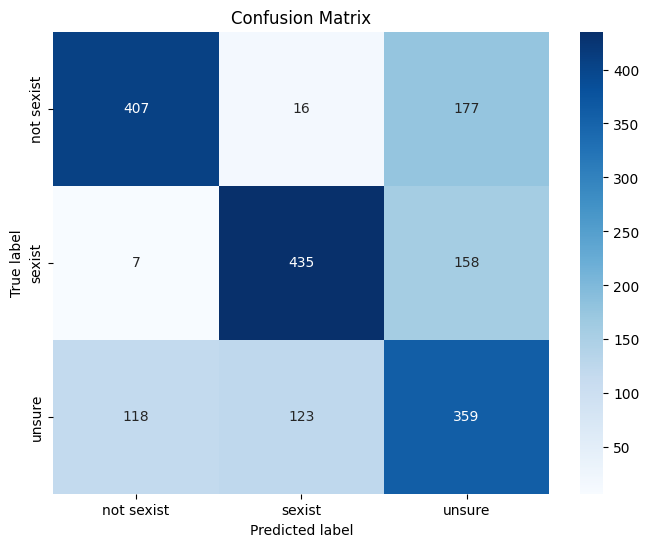

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.77      0.68      0.72       600
      sexist       0.76      0.72      0.74       600
      unsure       0.52      0.60      0.55       600

    accuracy                           0.67      1800
   macro avg       0.68      0.67      0.67      1800
weighted avg       0.68      0.67      0.67      1800

✅ Modelo guardado como mejor modelo (F1 = 0.6717)
Modelo y tokenizador guardados en /content/drive/My Drive/Facultad/Máster/TFM/Modelos/bert-base-uncased/edos_labelled_3_sexism_grade_reduced
label2id: {'not sexist': 0, 'sexist': 1, 'unsure': 2}
id2label: {0: 'not sexist', 1: 'sexist', 2: 'unsure'}
{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 16, 'eval_loss': 0.9858180284500122, 'eval_accuracy': 0.8159203980099502, 'eval_precision': 0.7921348314606742, 'eval_recall': 0.8511066398390342, 'eval_f1': 0.8205

Casting to class labels:   0%|          | 0/6300 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/900 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1800 [00:00<?, ? examples/s]

ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 1, 1, 0, 0, 0, 0, 0, 2, 2]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 0, 0, 1, 2, 0, 1]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 2, 1, 0, 0, 2, 2]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

/tmp/ipython-input-23-1023676812.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.828800,0.778498,0.630000,0.653547,0.630000,0.637216
2,0.608300,0.792509,0.637778,0.649952,0.637778,0.641931
3,0.392000,1.030032,0.636667,0.666112,0.636667,0.643725
4,0.246400,1.506129,0.640000,0.666333,0.640000,0.646667
5,0.157700,1.814232,0.637778,0.684217,0.637778,0.646996
6,0.102300,2.197824,0.651111,0.667906,0.651111,0.656673
7,0.091600,2.161375,0.626667,0.654625,0.626667,0.630939
8,0.066700,2.702399,0.625556,0.671486,0.625556,0.634981
9,0.030900,2.837443,0.632222,0.670055,0.632222,0.640896


Evaluando en el conjunto de test...


Test metrics: {'eval_loss': 2.1462180614471436, 'eval_accuracy': 0.6555555555555556, 'eval_precision': 0.6682569512705371, 'eval_recall': 0.6555555555555556, 'eval_f1': 0.6599993394507577, 'eval_runtime': 2.1251, 'eval_samples_per_second': 847.007, 'eval_steps_per_second': 53.173, 'epoch': 9.0}
Almacenando resultados: {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 16, 'eval_loss': 2.1462180614471436, 'eval_accuracy': 0.6555555555555556, 'eval_precision': 0.6682569512705371, 'eval_recall': 0.6555555555555556, 'eval_f1': 0.6599993394507577, 'eval_runtime': 2.1251, 'eval_samples_per_second': 847.007, 'eval_steps_per_second': 53.173, 'epoch': 9.0}


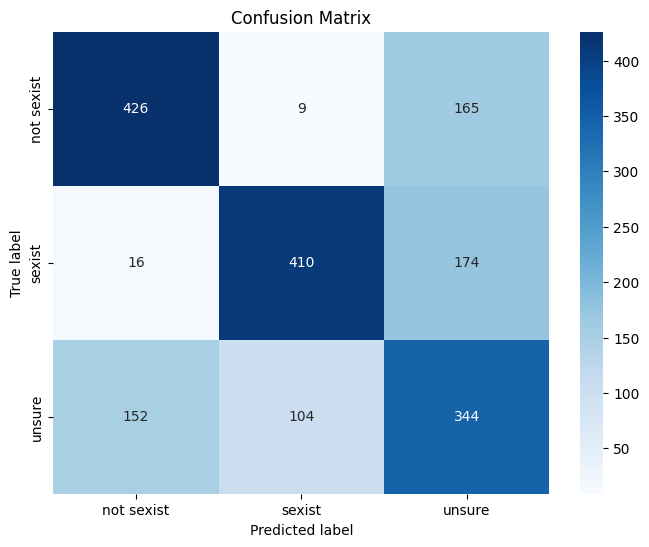

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.72      0.71      0.71       600
      sexist       0.78      0.68      0.73       600
      unsure       0.50      0.57      0.54       600

    accuracy                           0.66      1800
   macro avg       0.67      0.66      0.66      1800
weighted avg       0.67      0.66      0.66      1800

No se guarda el modelo: F1 actual (0.6600) < F1 máximo anterior (0.6717)
Modelo y tokenizador guardados en /content/drive/My Drive/Facultad/Máster/TFM/Modelos/bert-base-uncased/edos_labelled_3_sexism_grade_reduced
label2id: {'not sexist': 0, 'sexist': 1, 'unsure': 2}
id2label: {0: 'not sexist', 1: 'sexist', 2: 'unsure'}
{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.01, 'batch_size': 16, 'eval_loss': 0.4518200755119324, 'eval_accuracy': 0.8288557213930349, 'eval_precision': 0.8524945770065075, 'eval_recall': 0.790744466

Casting to class labels:   0%|          | 0/6300 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/900 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1800 [00:00<?, ? examples/s]

ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 1, 1, 0, 0, 0, 0, 0, 2, 2]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 0, 0, 1, 2, 0, 1]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 2, 1, 0, 0, 2, 2]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

/tmp/ipython-input-23-1023676812.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.841600,0.798153,0.625556,0.682590,0.625556,0.634932
2,0.664700,0.887722,0.620000,0.631989,0.620000,0.618704
3,0.382500,1.152418,0.614444,0.614469,0.614444,0.614430
4,0.241100,1.466634,0.628889,0.645867,0.628889,0.634554


Evaluando en el conjunto de test...


Test metrics: {'eval_loss': 0.7609475255012512, 'eval_accuracy': 0.6488888888888888, 'eval_precision': 0.6950209532407264, 'eval_recall': 0.648888888888889, 'eval_f1': 0.6572564367010977, 'eval_runtime': 2.0051, 'eval_samples_per_second': 897.707, 'eval_steps_per_second': 56.356, 'epoch': 4.0}
Almacenando resultados: {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.01, 'batch_size': 16, 'eval_loss': 0.7609475255012512, 'eval_accuracy': 0.6488888888888888, 'eval_precision': 0.6950209532407264, 'eval_recall': 0.648888888888889, 'eval_f1': 0.6572564367010977, 'eval_runtime': 2.0051, 'eval_samples_per_second': 897.707, 'eval_steps_per_second': 56.356, 'epoch': 4.0}


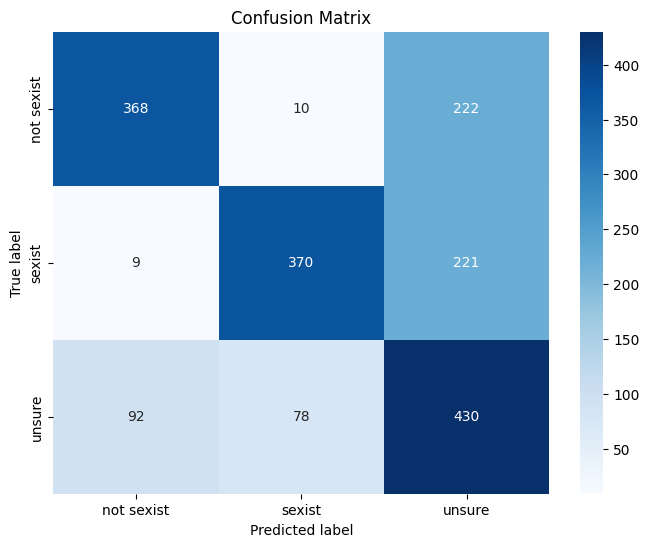

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.78      0.61      0.69       600
      sexist       0.81      0.62      0.70       600
      unsure       0.49      0.72      0.58       600

    accuracy                           0.65      1800
   macro avg       0.70      0.65      0.66      1800
weighted avg       0.70      0.65      0.66      1800

No se guarda el modelo: F1 actual (0.6573) < F1 máximo anterior (0.6717)
Modelo y tokenizador guardados en /content/drive/My Drive/Facultad/Máster/TFM/Modelos/bert-base-uncased/edos_labelled_3_sexism_grade_reduced
label2id: {'not sexist': 0, 'sexist': 1, 'unsure': 2}
id2label: {0: 'not sexist', 1: 'sexist', 2: 'unsure'}
{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.001, 'batch_size': 32, 'eval_loss': 0.4085188806056976, 'eval_accuracy': 0.8199004975124378, 'eval_precision': 0.8098039215686275, 'eval_recall': 0.83098591

Casting to class labels:   0%|          | 0/6300 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/900 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1800 [00:00<?, ? examples/s]

ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 1, 1, 0, 0, 0, 0, 0, 2, 2]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 0, 0, 1, 2, 0, 1]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 2, 1, 0, 0, 2, 2]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

/tmp/ipython-input-23-1023676812.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.953700,0.768704,0.637778,0.674954,0.637778,0.645271
2,0.633600,0.795210,0.631111,0.625826,0.631111,0.627963
3,0.342100,0.977661,0.636667,0.659745,0.636667,0.643003
4,0.174900,1.303319,0.611111,0.649614,0.611111,0.618215


Evaluando en el conjunto de test...


Test metrics: {'eval_loss': 0.738663375377655, 'eval_accuracy': 0.6594444444444445, 'eval_precision': 0.6901316664856173, 'eval_recall': 0.6594444444444445, 'eval_f1': 0.6669281775405681, 'eval_runtime': 1.3527, 'eval_samples_per_second': 1330.71, 'eval_steps_per_second': 42.139, 'epoch': 4.0}
Almacenando resultados: {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.001, 'batch_size': 32, 'eval_loss': 0.738663375377655, 'eval_accuracy': 0.6594444444444445, 'eval_precision': 0.6901316664856173, 'eval_recall': 0.6594444444444445, 'eval_f1': 0.6669281775405681, 'eval_runtime': 1.3527, 'eval_samples_per_second': 1330.71, 'eval_steps_per_second': 42.139, 'epoch': 4.0}


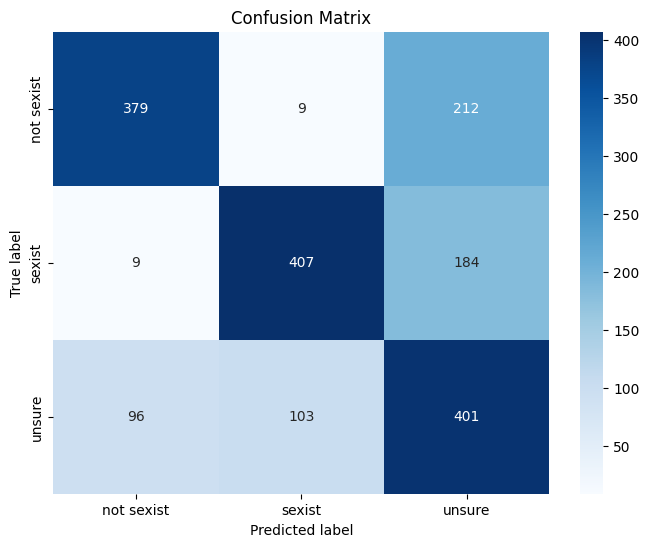

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.78      0.63      0.70       600
      sexist       0.78      0.68      0.73       600
      unsure       0.50      0.67      0.57       600

    accuracy                           0.66      1800
   macro avg       0.69      0.66      0.67      1800
weighted avg       0.69      0.66      0.67      1800

No se guarda el modelo: F1 actual (0.6669) < F1 máximo anterior (0.6717)
Modelo y tokenizador guardados en /content/drive/My Drive/Facultad/Máster/TFM/Modelos/bert-base-uncased/edos_labelled_3_sexism_grade_reduced
label2id: {'not sexist': 0, 'sexist': 1, 'unsure': 2}
id2label: {0: 'not sexist', 1: 'sexist', 2: 'unsure'}
{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.01, 'batch_size': 16, 'eval_loss': 0.6573847532272339, 'eval_accuracy': 0.8208955223880597, 'eval_precision': 0.8241308793456033, 'eval_recall': 0.810865191

Casting to class labels:   0%|          | 0/6300 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/900 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1800 [00:00<?, ? examples/s]

ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 1, 1, 0, 0, 0, 0, 0, 2, 2]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 0, 0, 1, 2, 0, 1]
ClassLabel(names=['not sexist', 'sexist', 'unsure'], id=None)
[2, 2, 0, 0, 2, 1, 0, 0, 2, 2]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6300 [00:00<?, ? examples/s]

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/1800 [00:00<?, ? examples/s]

/tmp/ipython-input-23-1023676812.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.846300,0.818345,0.622222,0.626674,0.622222,0.615911
2,0.630000,0.806687,0.638889,0.635335,0.638889,0.636740
3,0.350600,1.195262,0.620000,0.633746,0.620000,0.622232
4,0.258000,1.408833,0.634444,0.660320,0.634444,0.640356
5,0.179500,1.884100,0.650000,0.669629,0.650000,0.654152
6,0.156600,1.908764,0.614444,0.650796,0.614444,0.621634
7,0.086000,2.384938,0.613333,0.665966,0.613333,0.619745
8,0.075600,2.589377,0.627778,0.643893,0.627778,0.633422


Evaluando en el conjunto de test...


Test metrics: {'eval_loss': 1.7468997240066528, 'eval_accuracy': 0.6594444444444445, 'eval_precision': 0.6801292843414842, 'eval_recall': 0.6594444444444445, 'eval_f1': 0.6652892148077808, 'eval_runtime': 2.1513, 'eval_samples_per_second': 836.721, 'eval_steps_per_second': 52.527, 'epoch': 8.0}
Almacenando resultados: {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.01, 'batch_size': 16, 'eval_loss': 1.7468997240066528, 'eval_accuracy': 0.6594444444444445, 'eval_precision': 0.6801292843414842, 'eval_recall': 0.6594444444444445, 'eval_f1': 0.6652892148077808, 'eval_runtime': 2.1513, 'eval_samples_per_second': 836.721, 'eval_steps_per_second': 52.527, 'epoch': 8.0}


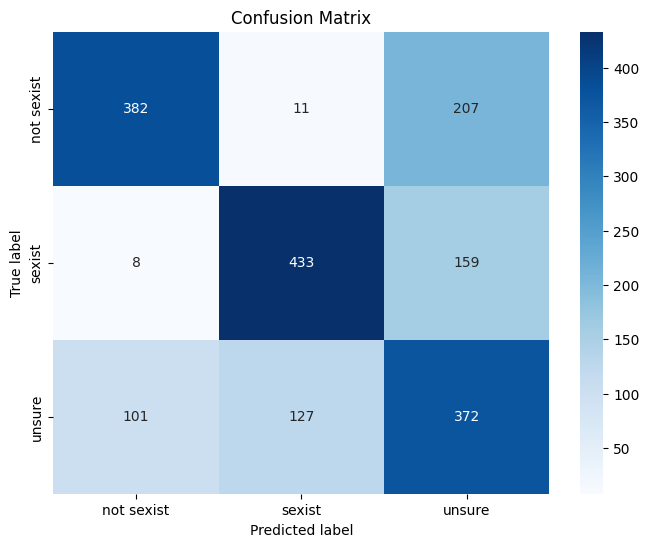

Classification Report:
               precision    recall  f1-score   support

  not sexist       0.78      0.64      0.70       600
      sexist       0.76      0.72      0.74       600
      unsure       0.50      0.62      0.56       600

    accuracy                           0.66      1800
   macro avg       0.68      0.66      0.67      1800
weighted avg       0.68      0.66      0.67      1800

No se guarda el modelo: F1 actual (0.6653) < F1 máximo anterior (0.6717)
Modelo y tokenizador guardados en /content/drive/My Drive/Facultad/Máster/TFM/Modelos/bert-base-uncased/edos_labelled_3_sexism_grade_reduced
label2id: {'not sexist': 0, 'sexist': 1, 'unsure': 2}
id2label: {0: 'not sexist', 1: 'sexist', 2: 'unsure'}


In [24]:
# Obtenemos los parámetros que vamos a modificar
f1_results = []
for params_group in top_5_results[model_name]:
  print(params_group)
  # Obtenemos los parámetros
  n_ep = params_group["num_epochs"]
  lr = params_group["learning_rate"]
  wd = params_group["weight_decay"]
  bs = params_group["batch_size"]

# for n_ep, lr, wd, bs in product(num_epochs, learning_rates, weight_decays, batch_sizes):
  # Comprobamos si no está ya ese resultado
  df_filtrado = df_results[(df_results['num_epochs'] == n_ep) &
   (df_results['learning_rate'] == lr) &
   (df_results['weight_decay'] == wd) &
    (df_results['batch_size'] == bs)]
  if df_filtrado.empty:
    # Entrena y obtiene métricas
    metrics = train_model(
        model_name=model_name,
        df=df,
        model_path=model_path,
        num_train_epochs=n_ep,
        strategy="epoch",
        learning_rate=lr,
        weight_decay=wd,
        batch_size=bs,
        save_model=True,
        f1_results=f1_results
    )

In [25]:
df_resultados_total = pd.DataFrame(all_results)
csv_result_all = carpeta_resultados + "/resultados_all.csv"
df_resultados_total.to_csv(csv_result_all, index=False)

In [26]:
print(len(all_results))

5


In [27]:
print(all_results)

[{'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 32, 'eval_loss': 0.7258923053741455, 'eval_accuracy': 0.6672222222222223, 'eval_precision': 0.6800561271739128, 'eval_recall': 0.6672222222222223, 'eval_f1': 0.6716687048543765, 'eval_runtime': 1.3323, 'eval_samples_per_second': 1351.061, 'eval_steps_per_second': 42.784, 'epoch': 4.0}, {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0, 'batch_size': 16, 'eval_loss': 2.1462180614471436, 'eval_accuracy': 0.6555555555555556, 'eval_precision': 0.6682569512705371, 'eval_recall': 0.6555555555555556, 'eval_f1': 0.6599993394507577, 'eval_runtime': 2.1251, 'eval_samples_per_second': 847.007, 'eval_steps_per_second': 53.173, 'epoch': 9.0}, {'model_name': 'bert-base-uncased', 'num_epochs': 20, 'strategy': 'epoch', 'learning_rate': 5e-05, 'weight_decay': 0.01, 'batch_size': 16, 'eval_loss': 0.76094752